In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

import pyfiles.models
import pyfiles.lib

In [2]:
num_noise = batch_size = 100
num_hidden = 256

In [3]:
# standardization code
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), ])

# MNIST dataset
train_data = torchvision.datasets.MNIST(root='data/', train=True, transform=transform, download=True)
test_data  = torchvision.datasets.MNIST(root='data/', train=False, transform=transform, download=True)

train_data_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

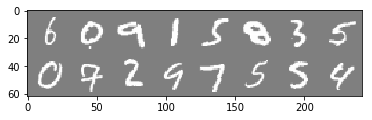

In [4]:
example_mini_batch_img, example_mini_batch_label  = next(iter(train_data_loader))
lib.imshow_grid(example_mini_batch_img[0:16,:,:])

torch.Size([100, 28, 28])


TypeError: Invalid dimensions for image data

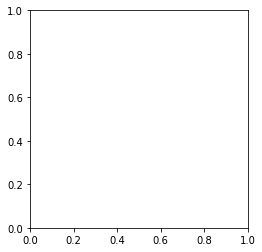

In [5]:
gen = models.Generator(num_noise)
disc = models.Discriminator()

# 노이즈 생성하기
z = lib.sample_noise(batch_size, num_noise)
# 가짜 이미지 생성하기
img_fake = gen(z)
# 이미지 출력하기
print(img_fake.squeeze().cpu().detach().shape)
lib.imshow(img_fake.squeeze().cpu().detach())

# Batch SIze만큼 노이즈 생성하여 그리드로 출력하기
z = lib.sample_noise(batch_size, num_noise)
img_fake = gen(z)
print(img_fake.shape)
lib.imshow_grid(img_fake)

In [6]:
criterion = torch.nn.BCELoss()

def run_epoch(generator, discriminator, _optimizer_g, _optimizer_d):
    
    generator.train()
    discriminator.train()

    for img_batch, label_batch in train_data_loader:

        if torch.cuda.is_available():
            img_batch  = img_batch.cuda()
            label_batch = label_batch.cuda()

        # Learn Discriminator
        _optimizer_d.zero_grad()

        p_real = discriminator(img_batch.view(batch_size, -1 , 28, 28))
        p_fake = discriminator(generator(lib.sample_noise(batch_size, num_noise)))
        
        ones = torch.ones_like(p_real)
        zeros = torch.zeros_like(p_real)
        if torch.cuda.is_available():
            ones = ones.cuda()
            zeros = zeros.cuda()

        loss_d = criterion(p_real, ones) + criterion(p_fake, zeros)
        
        # Update parameters
        loss_d.backward()
        _optimizer_d.step()

        # Clipping weights
        for params in discriminator.parameters():
            params = torch.clamp(params, -0.01, 0.01)

        # Learn Generator
        _optimizer_g.zero_grad()
        p_fake = discriminator(generator(lib.sample_noise(batch_size, num_noise)))
                
        ones = torch.ones_like(p_fake)
        if torch.cuda.is_available():
            ones = ones.cuda()

        loss_g = criterion(p_fake, ones)
        loss_g.backward()
   
        # Update parameters
        _optimizer_g.step()
          
def evaluate_model(generator, discriminator):
    
    p_real, p_fake = 0.,0.
    
    generator.eval()
    discriminator.eval()
        
    for img_batch, label_batch in test_data_loader:
        if torch.cuda.is_available():
            img_batch = img_batch.cuda()
            label_batch = label_batch.cuda()
        
        with torch.autograd.no_grad():
            p_real += (torch.sum(discriminator(img_batch.view(batch_size, -1 , 28, 28))).item())/10000.
            p_fake += (torch.sum(discriminator(generator(lib.sample_noise(batch_size, num_noise)))).item())/10000.
            
            
    return p_real, p_fake

(epoch 10/200) p_real: 0.848758, p_g: 0.106476


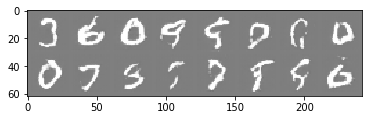

(epoch 20/200) p_real: 0.730045, p_g: 0.131269


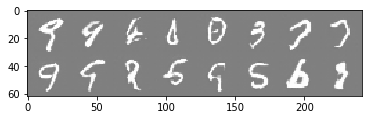

(epoch 30/200) p_real: 0.487065, p_g: 0.047069


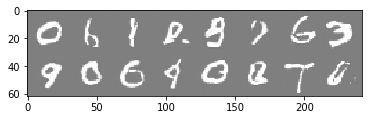

(epoch 40/200) p_real: 0.691145, p_g: 0.152760


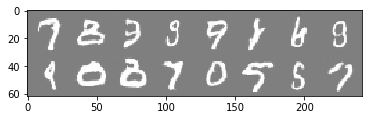

(epoch 50/200) p_real: 0.852083, p_g: 0.216676


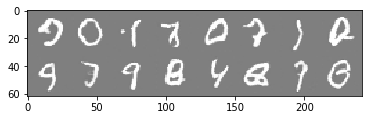

(epoch 60/200) p_real: 0.686263, p_g: 0.104220


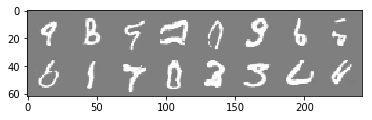

(epoch 70/200) p_real: 0.655841, p_g: 0.105860


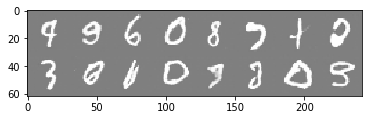

(epoch 80/200) p_real: 0.700387, p_g: 0.121982


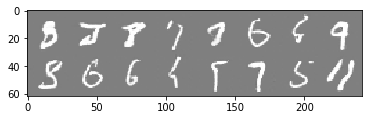

(epoch 90/200) p_real: 0.823659, p_g: 0.145805


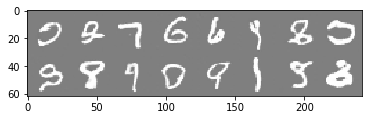

(epoch 100/200) p_real: 0.768374, p_g: 0.106884


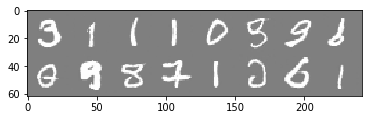

(epoch 110/200) p_real: 0.908017, p_g: 0.366229


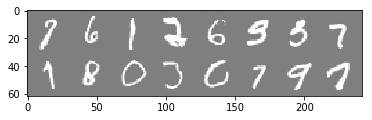

(epoch 120/200) p_real: 0.611285, p_g: 0.068926


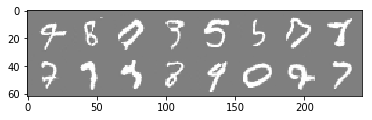

(epoch 130/200) p_real: 0.709579, p_g: 0.097678


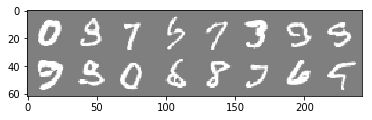

(epoch 140/200) p_real: 0.556076, p_g: 0.051480


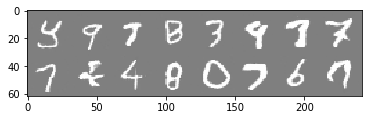

(epoch 150/200) p_real: 0.732635, p_g: 0.112803


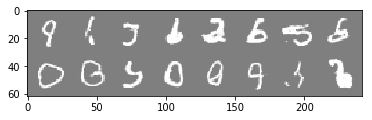

(epoch 160/200) p_real: 0.779267, p_g: 0.158702


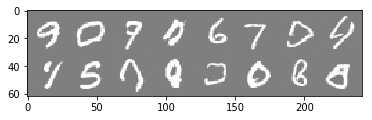

(epoch 170/200) p_real: 0.780567, p_g: 0.163076


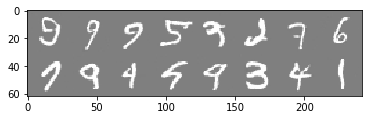

(epoch 180/200) p_real: 0.432652, p_g: 0.020286


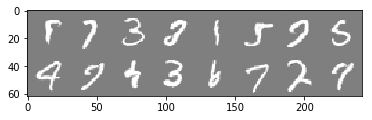

(epoch 190/200) p_real: 0.762816, p_g: 0.188190


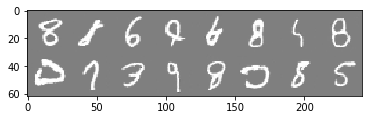

(epoch 200/200) p_real: 0.580468, p_g: 0.042661


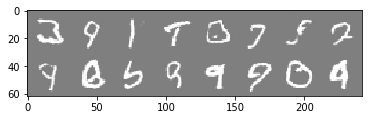

In [7]:
def init_params(model):
    for p in model.parameters():
        if(p.dim() > 1):
            torch.nn.init.xavier_normal_(p)
        else:
            torch.nn.init.uniform_(p, 0.1, 0.2)

init_params(gen)
init_params(disc)


optimizer_g = torch.optim.Adam(gen.parameters(), lr = 0.0002)
optimizer_d = torch.optim.Adam(disc.parameters(), lr = 0.0002)

p_real_trace = []
p_fake_trace = []

for epoch in range(200):
    run_epoch(gen, disc, optimizer_g, optimizer_d)
    p_real, p_fake = evaluate_model(gen,disc)
    
    p_real_trace.append(p_real)
    p_fake_trace.append(p_fake) 
    
    if((epoch+1)% 10 == 0):
        print('(epoch %i/200) p_real: %f, p_g: %f' % (epoch+1, p_real, p_fake))
        lib.imshow_grid(gen(lib.sample_noise(16, num_noise)).view(-1, 1, 28, 28))